# 的士调度 Taxi-v3

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import gym

### 环境使用

In [2]:
env = gym.make('Taxi-v3')
print('观察空间 = {}'.format(env.observation_space))
print('动作空间 = {}'.format(env.action_space))
print('状态数量 = {}'.format(env.observation_space.n))
print('动作数量 = {}'.format(env.action_space.n))

观察空间 = Discrete(500)
动作空间 = Discrete(6)
状态数量 = 500
动作数量 = 6


In [3]:
state, _ = env.reset()
taxirow, taxicol, passloc, destidx = env.unwrapped.decode(state)
print(taxirow, taxicol, passloc, destidx)
print('的士位置 = {}'.format((taxirow, taxicol)))
print('乘客位置 = {}'.format(env.unwrapped.locs[passloc]))
print('目标位置 = {}'.format(env.unwrapped.locs[destidx]))
# env.render()  # 与Jupyter Notebook不兼容

3 1 0 2
的士位置 = (3, 1)
乘客位置 = (0, 0)
目标位置 = (4, 0)


In [4]:
env.step(0)

(422,
 -1,
 False,
 False,
 {'prob': 1.0, 'action_mask': array([0, 1, 1, 0, 0, 0], dtype=int8)})

In [5]:
# env.render()  # 与Jupyter Notebook不兼容

### SARSA 算法

In [6]:
class SARSAAgent:
    def __init__(self, env, gamma=0.9, learning_rate=0.2, epsilon=.01):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))

    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = self.q[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action

    def learn(self, state, action, reward, next_state, terminated, truncated, next_action):
        u = reward + self.gamma * \
                self.q[next_state, next_action] * (1. - terminated)
        td_error = u - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error

In [7]:
def play_sarsa(env, agent, train=False, render=False):
    episode_reward = 0
    observation, _ = env.reset()
    action = agent.decide(observation)
    while True:
        if render:
            env.render()
        next_observation, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        next_action = agent.decide(next_observation) # 终止状态时此步无意义
        if train:
            agent.learn(observation, action, reward, next_observation,
                    terminated, truncated, next_action)
        if terminated or truncated:
            break
        observation, action = next_observation, next_action
    return episode_reward

平均回合奖励 = 780 / 100 = 7.8


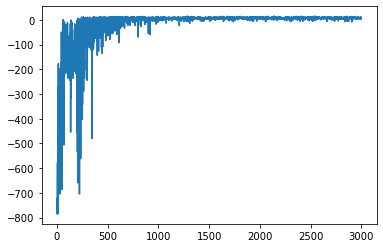

In [8]:
agent = SARSAAgent(env)

# 训练
episodes = 3000
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)

plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索

episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

显示最优价值估计

In [9]:
pd.DataFrame(agent.q)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-3.998727,-4.036675,-3.475138,-4.043107,1.457487,-5.469958
2,-1.062272,-2.267391,-2.364206,-2.322217,6.639410,-3.636000
3,-3.732938,-3.725796,-3.172617,-3.619717,2.485251,-5.796625
4,-5.978125,-6.030726,-5.788342,-5.984247,-7.071083,-8.417367
...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
496,-3.084939,-2.945210,-3.098091,-3.076834,-3.600000,-3.636000
497,-1.497421,-1.500430,-1.752257,-1.478360,-3.600000,-3.636000
498,-2.828607,-2.765789,-2.870962,-2.756544,-3.600000,-3.636000


显示最优策略估计

In [10]:
policy = np.eye(agent.action_n)[agent.q.argmax(axis=-1)]
pd.DataFrame(policy)

,0,1,2,3,4,5
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...
495,1.0,0.0,0.0,0.0,0.0,0.0
496,0.0,1.0,0.0,0.0,0.0,0.0
497,0.0,0.0,0.0,1.0,0.0,0.0
498,0.0,0.0,0.0,1.0,0.0,0.0


### 期望 SARSA

In [11]:
class ExpectedSARSAAgent:
    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=.01):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.q = np.zeros((env.observation_space.n, env.action_space.n))
        self.action_n = env.action_space.n

    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = self.q[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action

    def learn(self, state, action, reward, next_state, terminated, truncated):
        v = (self.q[next_state].mean() * self.epsilon + \
                self.q[next_state].max() * (1. - self.epsilon))
        u = reward + self.gamma * v * (1. - terminated)
        td_error = u - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error

In [12]:
def play_qlearning(env, agent, train=False, render=False):
    episode_reward = 0
    observation, _ = env.reset()
    while True:
        if render:
            env.render()
        action = agent.decide(observation)
        next_observation, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        if train:
            agent.learn(observation, action, reward, next_observation,
                    terminated, truncated)
        if terminated or truncated:
            break
        observation = next_observation
    return episode_reward

平均回合奖励 = 813 / 100 = 8.13


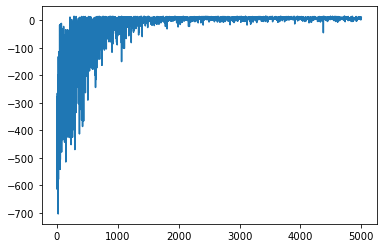

In [13]:
agent = ExpectedSARSAAgent(env)

# 训练
episodes = 5000
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)

plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索

episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

### Q 学习

In [14]:
class QLearningAgent:
    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=.01):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q = np.zeros((env.observation_space.n, env.action_space.n))

    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = self.q[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action

    def learn(self, state, action, reward, next_state, terminated, truncated):
        u = reward + self.gamma * self.q[next_state].max() * (1. - terminated)
        td_error = u - self.q[state, action]
        self.q[state, action] += self.learning_rate * td_error

平均回合奖励 = 617 / 100 = 6.17


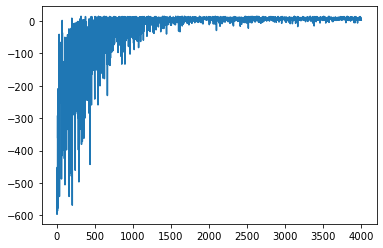

In [15]:
agent = QLearningAgent(env)

# 训练
episodes = 4000
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)

plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索

episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

### 双重 Q 学习

In [16]:
class DoubleQLearningAgent:
    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=.01):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.action_n = env.action_space.n
        self.q0 = np.zeros((env.observation_space.n, env.action_space.n))
        self.q1 = np.zeros((env.observation_space.n, env.action_space.n))

    def decide(self, state):
        if np.random.uniform() > self.epsilon:
            action = (self.q0 + self.q1)[state].argmax()
        else:
            action = np.random.randint(self.action_n)
        return action

    def learn(self, state, action, reward, next_state, terminated, truncated):
        if np.random.randint(2):
            self.q0, self.q1 = self.q1, self.q0
        a = self.q0[next_state].argmax()
        u = reward + self.gamma * self.q1[next_state, a] * (1. - terminated)
        td_error = u - self.q0[state, action]
        self.q0[state, action] += self.learning_rate * td_error

平均回合奖励 = -250 / 100 = -2.5


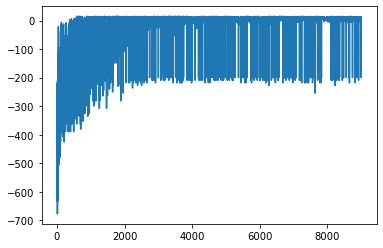

In [17]:
agent = DoubleQLearningAgent(env)

# 训练
episodes = 9000
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_qlearning(env, agent, train=True)
    episode_rewards.append(episode_reward)

plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索

episode_rewards = [play_qlearning(env, agent) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))

### SARSA($\lambda $) 算法

In [18]:
class SARSALambdaAgent(SARSAAgent):
    def __init__(self, env, lambd=0.6, beta=1.,
            gamma=0.9, learning_rate=0.1, epsilon=.01):
        super().__init__(env, gamma=gamma, learning_rate=learning_rate,
                epsilon=epsilon)
        self.lambd = lambd
        self.beta = beta
        self.e = np.zeros((env.observation_space.n, env.action_space.n))

    def learn(self, state, action, reward, next_state, terminated, truncated, next_action):
        # 更新资格迹
        self.e *= (self.lambd * self.gamma)
        self.e[state, action] = 1. + self.beta * self.e[state, action]

        # 更新价值
        u = reward + self.gamma * \
                self.q[next_state, next_action] * (1. - terminated)
        td_error = u - self.q[state, action]
        self.q += self.learning_rate * self.e * td_error
        if terminated or truncated:
            self.e *= 0.

平均回合奖励 = 780 / 100 = 7.8


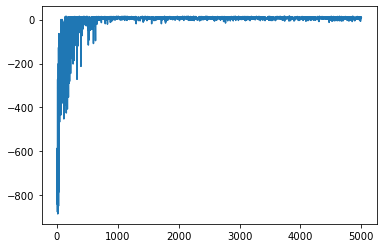

In [19]:
agent = SARSALambdaAgent(env)

# 训练
episodes = 5000
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)

plt.plot(episode_rewards)

# 测试
agent.epsilon = 0. # 取消探索

episode_rewards = [play_sarsa(env, agent, train=False) for _ in range(100)]
print('平均回合奖励 = {} / {} = {}'.format(sum(episode_rewards),
        len(episode_rewards), np.mean(episode_rewards)))